In [1]:
# Import packages
import os
import copy
from pathlib import Path
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import pandas as pd
import random
from pdb import set_trace

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, matthews_corrcoef

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# Dataset
Set = 'Protein' # Define the dataset to use, 'Protein', 'mRNA', or 'Protein + mRNA' are the options
# Define the Model
Model = 'PixelPreserve' # 'PixelPreserve' are the options
# Define the Model Path
#pth_path = 'saved_models/Protein_Mertins_Mito_NN3_model.pth'
pth_path = 'saved_models/Protein_NN3_model.pth' # Path to the saved model

### Testing

In [3]:
# Check to see if the GPU is available and store it as a variable so tensors can be moved to it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Is cuda available?:', torch.cuda.is_available())
print('cuda version:', torch.version.cuda)
dev = "cuda:0"

Using device: cuda
Is cuda available?: True
cuda version: 11.7


In [4]:
# Create run name
Run_Name = 'Prot + Mertins mito' # change run_name before running

# Paths
label_path = '/home/ec2-user/Jul2025/labels/' # label folder with all the labels
dataset_folder_path = '/home/ec2-user/Jul2025/processed_dataset3/' # dataset folder with all the processed proteome and mRNA data
model_folder_path = '/home/ec2-user/Jul2025/saved_models/' # model folder with all the models

# Define the Model
Model = 'PixelPreserve' # 'PixelPreserve' are the options

# Dataset
Set = 'Protein' # Define the dataset to use, 'Protein', 'mRNA', or 'Protein + mRNA' are the options

# Image size
Canvas_Size = 18

# Seed number
Seed = 43

# Validation fraction
Validation_Fraction = 0.2

# Standard deviation for add-noise transformation
StandardDeviation = 0.005 # 0.005 so far is better

# Learning rate scheduler
Learner_rate = 1e-4

# Optimizer
Weight_Decay = 0.0001 # L2 regulator
#  it works by adding a penalty to the loss function, which discourages large weights in the model; penalizes for too many weights - helps prevent overfitting
#  the penalty is calculated as weight_decay * weight^2, and it's added to the loss.
#  1e-4 or 1e-3 gives higher acc

# Batch size
Batch_size = 64


In [5]:
def set_seed(seed):
    random.seed(seed) # set random seed for python
    np.random.seed(seed) # set random seed for numpy
    torch.manual_seed(seed) # set random seed for CPU
    rs = RandomState(MT19937(SeedSequence(seed))) # seed for numpy
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # set random seed for all GPUs
    torch.backends.cudnn.deterministic = True # set to True to get reproducible results
    torch.backends.cudnn.benchmark = False # set to False to get reproducible results

In [6]:
def gen_horizontal_coords(n, num_points):
    """
    Generate coordinates for a horizontal pattern starting from the top-left corner.

    Parameters:
    n (int): Size of the canvas (n x n).
    num_points (int): Number of points to generate in the horizontal pattern.

    Returns:
    list: List of (x, y) coordinates in horizontal order.
    """
    coords = [(x, y) for x in range(n) for y in range(n)]
    return coords[:num_points]

def create_rgb_tensors(set, interleaved_array):
    """
    Create RGB tensors from abundance data using the specified pattern.
    
    Parameters:
    set (str): Dataset used for plotting ('Protein', 'mRNA', 'Protein + mRNA').
    df1 (pd.DataFrame): DataFrame containing normalized abundance data.
    df2 (pd.DataFrame): DataFrame containing normalized abundance data.
    
    Returns:
    torch.Tensor: RGB tensor.
    """

    interleaved_array = interleaved_array.flatten()
    num_pixels = len(interleaved_array)
    
    # Generate coordinates based on the pattern, spiral or horizontal arrangment
    coords = gen_horizontal_coords(Canvas_Size, num_pixels)

    # Create RGB tensor
    rgb_tensor = np.zeros((Canvas_Size, Canvas_Size, 3), dtype=np.float32)
    for i, (x, y) in enumerate(coords):
        if i < len(interleaved_array):
            value = interleaved_array[i]
            # Assign colors based on the value, if abundance > 1, set it to red, if abundance < 0, set it to blue.
            #if value > 1:
            #    rgb_tensor[x, y] = [255, 0, 0]  # Red for value > 1
            #elif value < 0:
            #    rgb_tensor[x, y] = [0, 0, 255]  # Blue for value < 0
            #else:
            rgb_tensor[x, y] = [255 * value, 0, 255 * (1 - value)]

    return torch.from_numpy(rgb_tensor.transpose(2, 0, 1))  # Convert to CHW format for PyTorch

In [7]:
class MyDataset(Dataset):
    def __init__(self, set, data1, data2, indices, labels, transform=None):

        assert data1.loc[indices,:].shape[0] == data2.loc[indices,:].shape[0] == len(labels), \
            "Protein, mRNA, and labels must have the same number of samples (rows)"

        self.set = set
        self.data1 = data1.loc[indices,:]
        self.data2 = data2.loc[indices,:]
        self.indices = indices
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        data1 = self.data1.iloc[idx].values
        data2 = self.data2.iloc[idx].values

        if self.transform:  
            data1, data2 = self.transform(data1, data2)

        abundance_sum = data1 + data2
        sorted_idx = abundance_sum.argsort()

        # Interleave
        interleaved_data = np.empty((len(data1) + len(data2)), dtype=np.float32)
        interleaved_data[0::2] = data1[sorted_idx]
        interleaved_data[1::2] = data2[sorted_idx]

        # Create RGB tensor
        sample = create_rgb_tensors(self.set, interleaved_data)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        index = self.indices[idx]

        return sample, label, index

    def __len__(self):
        return len(self.labels)

    def get_labels(self):
        return self.labels

In [8]:
# Open the labels data
LFP = 'markers.txt'
LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')
# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

In [9]:
# Labels
localization_labels = LD.loc[:, 'Localization'].values
unique_labels = set(localization_labels)  # Get unique labels
label_to_int = {
    'Cytosol': 0,
    'Mitochondria': 1,
    'Nucleus': 2,
    'Secretory': 3
}
int_to_label = {v: k for k, v in label_to_int.items()}
int_to_label

{0: 'Cytosol', 1: 'Mitochondria', 2: 'Nucleus', 3: 'Secretory'}

In [10]:
class PixelPreservingNet(nn.Module):
    def __init__(self, in_channels=3):
        super(PixelPreservingNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Shape is reduced by half

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )  # Shape remains same after padding

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.3)  
        )

        # Fully connected layers
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling layer
        self.fc1 = nn.Sequential(
            nn.Linear(256, 512), #256->512
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256), #512->256
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # Output layer
        self.output = nn.Linear(256, 4) #256->4
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.output(x)
        return x

model = PixelPreservingNet(in_channels=3).to(device)

In [11]:
# Function to calculate the precision and recall
def calculate_metrics(dataloader, model):
    y_pred = []
    y_true = []
    correct_indices = []
    incorrect_indices = []
    
    model.eval()
    with torch.no_grad():
        
        # iterate over validation data
        for X, y, idx in dataloader:
            
            X = X.to(torch.float32)
            X = X.to(device)
            output = model(X)  # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)  # Save Prediction

            labels = y.cpu().numpy()
            y_true.extend(labels)  # Save Truth

            correct_mask = (output == labels)
            incorrect_mask = ~correct_mask
            for i in range(len(idx)):
                if correct_mask[i]:
                    # If the prediction is correct, save the index
                    correct_indices.append(idx[i])
                else:
                    # If the prediction is incorrect, save the index
                    incorrect_indices.append(idx[i])

    # Calculate confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Calculate precision and recall for each class
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    mcc = matthews_corrcoef(y_true, y_pred)

    return cf_matrix, precision, recall, macro_f1, mcc, correct_indices, incorrect_indices

In [12]:
# make a function that visualize 5 confusion matrices from 5 data loaders, and stack them into one figure, 3 by 2
def plot_confusion_matrices(cf_matrices, labels, title):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.flatten()
    
    for i, cf_matrix in enumerate(cf_matrices):
        sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=labels, yticklabels=labels, ax=axes[i])
        #axes[i].set_xlabel('Predicted')
        #axes[i].set_ylabel('True')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].set_title(title[i])
    
    # remove the last empty subplot
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    # set an overall x and y label for the entire figure
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the title
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.text(0.5, 0, 'Predicted', ha='center', fontdict={'size': 16})
    fig.text(0, 0.5, 'True', va='center', rotation='vertical', fontdict={'size': 16})

    #fig.xlabel('Predicted')
    #fig.ylabel('True')
    plt.tight_layout()
    plt.show()

In [13]:
# Load the model
last_model = PixelPreservingNet(in_channels=3)
last_model.load_state_dict(torch.load(pth_path))
last_model.to(device)

PixelPreservingNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [14]:
# Read in the synthetic data
# Mertins 
#  proteome
M_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_PD_synthetic_kde_june.csv'))
M_PD_synthetic.index = M_PD_synthetic.loc[:,'Unnamed: 0']
M_PD_synthetic = M_PD_synthetic.loc[:, M_PD_synthetic.columns!='Unnamed: 0']

#   transcriptome
M_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_MD_synthetic_kde_june.csv'))
M_MD_synthetic.index = M_MD_synthetic.loc[:,'Unnamed: 0']
M_MD_synthetic = M_MD_synthetic.loc[:, M_MD_synthetic.columns!='Unnamed: 0']

# LCSCC tumor
#   proteome
lung_tumor_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_tumor_PD_synthetic_kde_june.csv'))
lung_tumor_PD_synthetic.index = lung_tumor_PD_synthetic.loc[:,'Unnamed: 0']
lung_tumor_PD_synthetic = lung_tumor_PD_synthetic.loc[:, lung_tumor_PD_synthetic.columns!='Unnamed: 0']

#   transcriptome
lung_tumor_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_tumor_MD_synthetic_kde_june.csv'))
lung_tumor_MD_synthetic.index = lung_tumor_MD_synthetic.loc[:,'Unnamed: 0']
lung_tumor_MD_synthetic = lung_tumor_MD_synthetic.loc[:, lung_tumor_MD_synthetic.columns!='Unnamed: 0']

# LCSCC NAT
#   proteome
lung_nat_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_nat_PD_synthetic_kde_june.csv'))
lung_nat_PD_synthetic.index = lung_nat_PD_synthetic.loc[:,'Unnamed: 0']
lung_nat_PD_synthetic = lung_nat_PD_synthetic.loc[:, lung_nat_PD_synthetic.columns!='Unnamed: 0']

#   transcriptome
lung_nat_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'lung_nat_MD_synthetic_kde_june.csv'))
lung_nat_MD_synthetic.index = lung_nat_MD_synthetic.loc[:,'Unnamed: 0']
lung_nat_MD_synthetic = lung_nat_MD_synthetic.loc[:, lung_nat_MD_synthetic.columns!='Unnamed: 0']

# Brain glioma
#   proteome
glioma_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'glioma_tumor_PD_synthetic_kde_june.csv'))
glioma_PD_synthetic.index = glioma_PD_synthetic.loc[:,'gene_name']
glioma_PD_synthetic = glioma_PD_synthetic.loc[:, glioma_PD_synthetic.columns!='gene_name']

#   transcriptome
glioma_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'glioma_tumor_MD_synthetic_kde_june.csv'))
glioma_MD_synthetic.index = glioma_MD_synthetic.loc[:,'gene_name']
glioma_MD_synthetic = glioma_MD_synthetic.loc[:, glioma_MD_synthetic.columns!='gene_name']

In [15]:
# Breast
# Read in the label
LD_mcf7 = pd.read_csv(Path(label_path+'markers.txt'), sep='\t')
LD_mcf7.index = LD_mcf7.loc[:,'Protein']
LD_mcf7 = LD_mcf7.loc[:,LD_mcf7.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_mcf7.loc[:,'Localization'] != 'Unclassified'
LD_mcf7 = LD_mcf7.loc[NotUnclassInd,:]

# Lung
LD_h322 = pd.read_csv(Path(label_path+'markers.txt'), sep='\t')
LD_h322.index = LD_h322.loc[:,'Protein']
LD_h322 = LD_h322.loc[:,LD_h322.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_h322.loc[:,'Localization'] != 'Unclassified'
LD_h322 = LD_h322.loc[NotUnclassInd,:]

# Lung
LD_u251 = pd.read_csv(Path(label_path+'markers.txt'), sep='\t')
LD_u251.index = LD_u251.loc[:,'Protein']
LD_u251 = LD_u251.loc[:,LD_u251.columns!='Protein']

# Remove unclassified
NotUnclassInd = LD_u251.loc[:,'Localization'] != 'Unclassified'
LD_u251 = LD_u251.loc[NotUnclassInd,:]

In [16]:
M_common_indices = list(set(M_PD_synthetic.index).intersection(set(M_MD_synthetic.index).intersection(set(LD_mcf7.index))))
M_LD = LD_mcf7.loc[LD_mcf7.index.isin(M_common_indices)]
M_PD_synthetic = M_PD_synthetic.loc[M_PD_synthetic.index.isin(M_common_indices)]
M_MD_synthetic = M_MD_synthetic.loc[M_MD_synthetic.index.isin(M_common_indices)]

lung_tumor_common_indices = list(set(lung_tumor_PD_synthetic.index).intersection(set(lung_tumor_MD_synthetic.index).intersection(set(LD_h322.index))))
lung_tumor_LD = LD_h322.loc[LD_h322.index.isin(lung_tumor_common_indices)]
lung_tumor_PD_synthetic = lung_tumor_PD_synthetic.loc[lung_tumor_PD_synthetic.index.isin(lung_tumor_common_indices)]
lung_tumor_MD_synthetic = lung_tumor_MD_synthetic.loc[lung_tumor_MD_synthetic.index.isin(lung_tumor_common_indices)]

lung_nat_common_indices = list(set(lung_nat_PD_synthetic.index).intersection(set(lung_nat_MD_synthetic.index).intersection(set(LD_h322.index))))
lung_nat_LD = LD_h322.loc[LD_h322.index.isin(lung_nat_common_indices)]
lung_nat_PD_synthetic = lung_nat_PD_synthetic.loc[lung_nat_PD_synthetic.index.isin(lung_nat_common_indices)]
lung_nat_MD_synthetic = lung_nat_MD_synthetic.loc[lung_nat_MD_synthetic.index.isin(lung_nat_common_indices)]

glioma_common_indices = list(set(glioma_PD_synthetic.index).intersection(set(glioma_MD_synthetic.index).intersection(set(LD_u251.index))))
glioma_LD = LD_u251.loc[LD_u251.index.isin(glioma_common_indices)]
glioma_PD_synthetic = glioma_PD_synthetic.loc[glioma_PD_synthetic.index.isin(glioma_common_indices)]
glioma_MD_synthetic = glioma_MD_synthetic.loc[glioma_MD_synthetic.index.isin(glioma_common_indices)]

# Convert string labels to integers
M_test_labels = [label_to_int[label] for label in M_LD['Localization'].values]
lung_tumor_test_labels = [label_to_int[label] for label in lung_tumor_LD['Localization'].values]
lung_nat_test_labels = [label_to_int[label] for label in lung_nat_LD['Localization'].values]
glioma_test_labels = [label_to_int[label] for label in glioma_LD['Localization'].values]

# Create the test datasets
if Set == 'Protein':
    M_test_dataset = MyDataset(Set, M_PD_synthetic, M_PD_synthetic, M_PD_synthetic.index, M_test_labels)
    lung_tumor_test_dataset = MyDataset(Set, lung_tumor_PD_synthetic, lung_tumor_PD_synthetic, lung_tumor_PD_synthetic.index, lung_tumor_test_labels)
    lung_nat_test_dataset = MyDataset(Set, lung_nat_PD_synthetic, lung_nat_PD_synthetic, lung_nat_PD_synthetic.index, lung_nat_test_labels)
    glioma_test_dataset = MyDataset(Set, glioma_PD_synthetic, glioma_PD_synthetic, glioma_PD_synthetic.index, glioma_test_labels)
elif Set == 'mRNA':
    # M_test_dataset = MyDataset(Set, M_MD_synthetic, M_MD_synthetic, M_MD_synthetic.index, M_test_labels)
    lung_tumor_test_dataset = MyDataset(Set, lung_tumor_MD_synthetic, lung_tumor_MD_synthetic, lung_tumor_MD_synthetic.index, lung_tumor_test_labels)
    lung_nat_test_dataset = MyDataset(Set, lung_nat_MD_synthetic, lung_nat_MD_synthetic, lung_nat_MD_synthetic.index, lung_nat_test_labels)
    glioma_test_dataset = MyDataset(Set, glioma_MD_synthetic, glioma_MD_synthetic, glioma_MD_synthetic.index, glioma_test_labels)
elif Set == 'Protein + mRNA':
    # M_test_dataset = MyDataset(Set, M_PD_synthetic, M_MD_synthetic, M_PD_synthetic.index, M_test_labels)
    lung_tumor_test_dataset = MyDataset(Set, lung_tumor_PD_synthetic, lung_tumor_MD_synthetic, lung_tumor_PD_synthetic.index, lung_tumor_test_labels)
    lung_nat_test_dataset = MyDataset(Set, lung_nat_PD_synthetic, lung_nat_MD_synthetic, lung_nat_PD_synthetic.index, lung_nat_test_labels)
    glioma_test_dataset = MyDataset(Set, glioma_PD_synthetic, glioma_MD_synthetic, glioma_PD_synthetic.index, glioma_test_labels)
else:
    raise ValueError("Invalid dataset selection. Choose 'Protein', 'mRNA', 'Protein + mRNA', 'Protein + mRNA Stack'.")

# Create the test data loaders
set_seed(Seed)
M_test_loader = DataLoader(M_test_dataset, batch_size=Batch_size, shuffle=False)
lung_tumor_test_loader = DataLoader(lung_tumor_test_dataset, batch_size=Batch_size, shuffle=False)
lung_nat_test_loader = DataLoader(lung_nat_test_dataset, batch_size=Batch_size, shuffle=False)
glioma_test_loader = DataLoader(glioma_test_dataset, batch_size=Batch_size, shuffle=False)

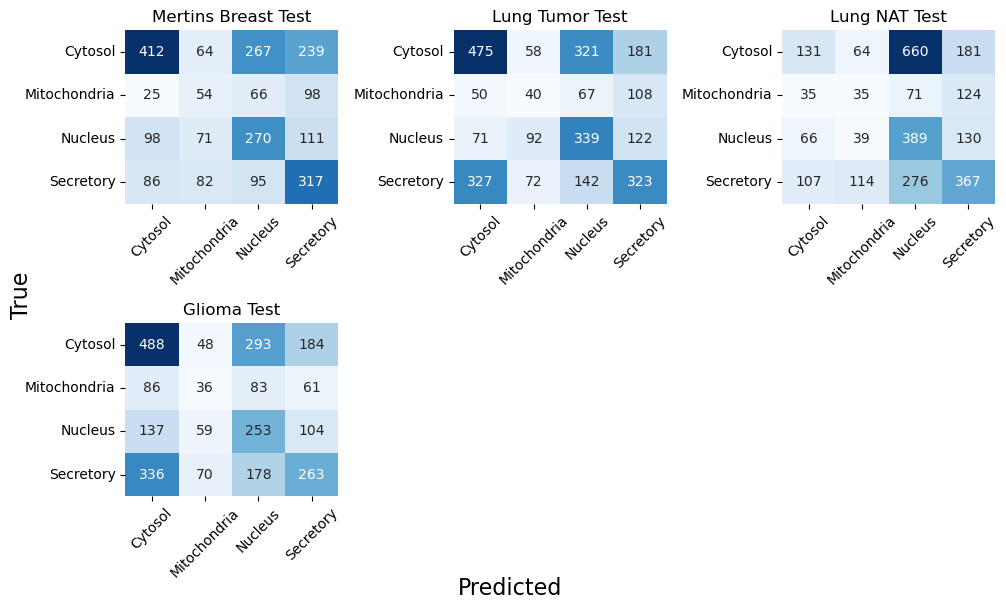

<Figure size 640x480 with 0 Axes>

In [17]:
# Set seed
#set_seed(Seed)

# Get the confusion matrix and precision and recall for the validation loader and all test loaders
cf_matrix_M, precision_M, recall_M, macro_f1_M, mcc_M, correct_indices_M, incorrect_indices_M = calculate_metrics(M_test_loader, last_model)    
cf_matrix_lung_tumor, precision_lung_tumor, recall_lung_tumor, macro_f1_lung_tumor, mcc_lung_tumor, correct_indices_lung_tumor, incorrect_indices_lung_tumor = calculate_metrics(lung_tumor_test_loader, last_model)
cf_matrix_lung_nat, precision_lung_nat, recall_lung_nat, macro_f1_lung_nat, mcc_lung_nat, correct_indices_lung_nat, incorrect_indices_lung_nat = calculate_metrics(lung_nat_test_loader, last_model)
cf_matrix_glioma, precision_glioma, recall_glioma, macro_f1_glioma, mcc_glioma, correct_indices_glioma, incorrect_indices_glioma = calculate_metrics(glioma_test_loader, last_model)

# Put them into a list
cf_matrices = [cf_matrix_M, cf_matrix_lung_tumor, cf_matrix_lung_nat, cf_matrix_glioma]
titles = ['Mertins Breast Test', 'Lung Tumor Test', 'Lung NAT Test', 'Glioma Test']

# Plot the confusion matrices
plot_confusion_matrices(cf_matrices, labels=int_to_label.values(), title=titles)

# Save figure into figure bank
figure3 = plt.gcf()
#figure3.savefig(Path(fig_bank_path+Set+'_Confusion_Matrices.png'), dpi=300)

### Enrichment

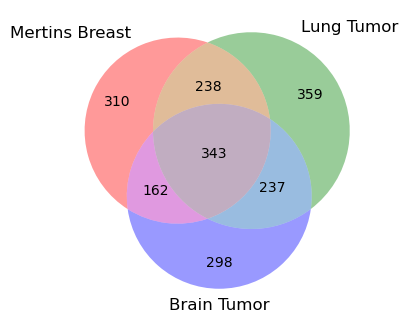

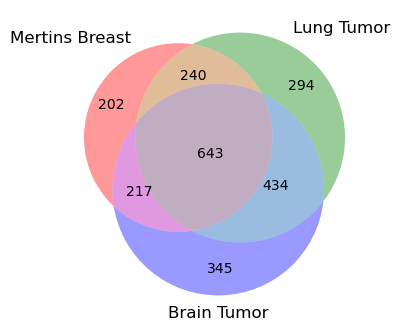

In [18]:
# Do a venn diagram of the correct indices
from matplotlib_venn import venn2, venn3
def plot_venn_diagram(sets, labels, filename=''):
    """
    Plot a Venn diagram for the given sets.
    
    Parameters:
    sets (list): List of sets to plot.
    labels (list): List of labels for the sets.
    """
    plt.figure(figsize=(4, 4))
    
    if len(sets) == 2:
        venn2(subsets=sets, set_labels=labels)
    elif len(sets) == 3:
        venn3(subsets=sets, set_labels=labels)
    else:
        raise ValueError("Only 2 or 3 sets are supported for Venn diagrams.")
    
    #plt.title('Venn Diagram of Correct Predictions')
    plt.savefig(f'Enrichr_prot/{Set}_{filename}_Venn.pdf', dpi=300)
    plt.show()

# Create sets for the correct indices
correct_sets = [
    set(correct_indices_M),
    set(correct_indices_lung_tumor),
    set(correct_indices_glioma)
]

incorrect_sets = [
    set(incorrect_indices_M),
    set(incorrect_indices_lung_tumor),
    set(incorrect_indices_glioma)
]

correct_lung_sets = [
    set(correct_indices_lung_tumor),
    set(correct_indices_lung_nat),
]

incorrect_lung_sets = [
    set(incorrect_indices_lung_tumor),
    set(incorrect_indices_lung_nat),
]

# Define labels for the sets
labels = ['Mertins Breast', 'Lung Tumor', 'Brain Tumor'] # ,
# Plot the Venn diagram
plot_venn_diagram(correct_sets, labels, filename='Tumor_Correct')
# Plot the Venn diagram for incorrect indices
plot_venn_diagram(incorrect_sets, labels, filename='Tumor_Incorrect')
# Plot the Venn diagram for lung tumor and lung NAT
#plot_venn_diagram(correct_lung_sets, ['Lung Tumor', 'Lung NAT'], filename='Lung_Correct')
# Plot the Venn diagram for incorrect lung tumor and lung NAT
#plot_venn_diagram(incorrect_lung_sets, ['Lung Tumor', 'Lung NAT'], filename='Lung_Incorrect')

In [19]:
enrichr_path = '/home/ec2-user/Jul2025/Enrichr_prot'

In [20]:
# Save the correct indices in each dataset to a file
def save_correct_indices_to_file(correct_indices, filename):
    with open(filename, 'w') as f:
        for index in correct_indices:
            f.write(f"{index}\n")
# Save the correct indices for each dataset
save_correct_indices_to_file(correct_indices_M, Path(enrichr_path) / f'{Set}_Mertins_Breast_correct_indices.txt')
save_correct_indices_to_file(correct_indices_lung_tumor, Path(enrichr_path) / f'{Set}_Lung_Tumor_correct_indices.txt')
#save_correct_indices_to_file(correct_indices_lung_nat, Path(enrichr_path) / f'{Set}_Lung_NAT_correct_indices.txt')
save_correct_indices_to_file(correct_indices_glioma, Path(enrichr_path) / f'{Set}_Glioma_correct_indices.txt')

# Save the incorrect indices in each dataset to a file
def save_incorrect_indices_to_file(incorrect_indices, filename):
    with open(filename, 'w') as f:
        for index in incorrect_indices:
            f.write(f"{index}\n")
# Save the incorrect indices for each dataset
save_incorrect_indices_to_file(incorrect_indices_M, Path(enrichr_path) / f'{Set}_Mertins_Breast_incorrect_indices.txt')
save_incorrect_indices_to_file(incorrect_indices_lung_tumor, Path(enrichr_path) / f'{Set}_Lung_Tumor_incorrect_indices.txt')
#save_incorrect_indices_to_file(incorrect_indices_lung_nat, Path(enrichr_path) / f'{Set}_Lung_NAT_incorrect_indices.txt')
save_incorrect_indices_to_file(incorrect_indices_glioma, Path(enrichr_path) / f'{Set}_Glioma_incorrect_indices.txt')

In [21]:
# Retreive the list of correct indices that are in common between the three sets
common_correct_indices = set.intersection(*correct_sets)
# Convert the set to a list
common_correct_indices_list = list(common_correct_indices)
# Print the number of common correct indices
print(f"Number of common tumor correct indices: {len(common_correct_indices_list)}")
# Save the common correct indices to a file
with open(Path(enrichr_path) / f'{Set}_tumor_common_correct_indices.txt', 'w') as f:
    for index in common_correct_indices_list:
        f.write(f"{index}\n")

# Retreive the list of incorrect indices that are in common between the three sets
common_incorrect_indices = set.intersection(*incorrect_sets)
# Convert the set to a list
common_incorrect_indices_list = list(common_incorrect_indices)
# Print the number of common incorrect indices
print(f"Number of common tumor incorrect indices: {len(common_incorrect_indices_list)}")
# Save the common incorrect indices to a file
with open(Path(enrichr_path) / f'{Set}_tumor_common_incorrect_indices.txt', 'w') as f:
    for index in common_incorrect_indices_list:
        f.write(f"{index}\n")

# Retreive the list of correct indices that are in common between the lung tumor and lung NAT sets
common_correct_lung_indices = set.intersection(*correct_lung_sets)
# Convert the set to a list
common_correct_lung_indices_list = list(common_correct_lung_indices)
# Print the number of common correct lung indices
print(f"Number of common lung correct indices: {len(common_correct_lung_indices_list)}")
# Save the common correct lung indices to a file
with open(Path(enrichr_path) / f'{Set}_lung_common_correct_indices.txt', 'w') as f:
    for index in common_correct_lung_indices_list:
        f.write(f"{index}\n")

# Retreive the list of incorrect indices that are in common between the lung tumor and lung NAT sets
common_incorrect_lung_indices = set.intersection(*incorrect_lung_sets)
# Convert the set to a list
common_incorrect_lung_indices_list = list(common_incorrect_lung_indices)
# Print the number of common incorrect lung indices
print(f"Number of common lung incorrect indices: {len(common_incorrect_lung_indices_list)}")
# Save the common incorrect lung indices to a file
with open(Path(enrichr_path) / f'{Set}_lung_common_incorrect_indices.txt', 'w') as f:
    for index in common_incorrect_lung_indices_list:
        f.write(f"{index}\n")

Number of common tumor correct indices: 343
Number of common tumor incorrect indices: 643
Number of common lung correct indices: 522
Number of common lung incorrect indices: 1212


In [22]:
# Use the correct indices to get the corresponding labels from LD, and print out how many compartments 
# are predictted correctly in each set

def get_labels_from_indices(indices, LD):
    """    Get the labels from the indices and LD DataFrame.

    Parameters:
    indices (list): List of indices to get labels for.
    LD (pd.DataFrame): DataFrame containing labels.

    Returns:
    list: List of labels corresponding to the indices.
    """
    labels = []
    for index in indices:
        if index in LD.index:
            labels.append(LD.loc[index, 'Localization'])
        else:
            labels.append('Unknown')
    return labels

# Get the labels for the correct indices in each dataset
M_correct_labels = get_labels_from_indices(correct_indices_M, M_LD)
lung_tumor_correct_labels = get_labels_from_indices(correct_indices_lung_tumor, lung_tumor_LD)
lung_nat_correct_labels = get_labels_from_indices(correct_indices_lung_nat, lung_nat_LD)
glioma_correct_labels = get_labels_from_indices(correct_indices_glioma, glioma_LD)

# Count the number of correct predictions for each compartment
def count_correct_predictions(labels):
    """Count the number of correct predictions for each compartment.
    
    Parameters:
    labels (list): List of labels to count. 
    Returns:
    dict: Dictionary with compartments as keys and counts as values.
    """
    compartment_counts = {label: 0 for label in label_to_int.keys()}
    for label in labels:
        if label in compartment_counts:
            compartment_counts[label] += 1
    return compartment_counts

# Count the correct predictions for each dataset
M_correct_counts = count_correct_predictions(M_correct_labels)
lung_tumor_correct_counts = count_correct_predictions(lung_tumor_correct_labels)
lung_nat_correct_counts = count_correct_predictions(lung_nat_correct_labels)
glioma_correct_counts = count_correct_predictions(glioma_correct_labels)

print(f"Mertins Correct Counts: {M_correct_counts}", sum(M_correct_counts.values()))
print(f"Lung Tumor Correct Counts: {lung_tumor_correct_counts}", sum(lung_tumor_correct_counts.values()))
#print(f"Lung Nat Correct Counts: {lung_nat_correct_counts}", sum(lung_nat_correct_counts.values()))
print(f"Glioma Correct Counts: {glioma_correct_counts}", sum(glioma_correct_counts.values()))

# Count the incorrect predictions for each dataset
def count_incorrect_predictions(labels):
    """Count the number of incorrect predictions for each compartment.
    
    Parameters:
    labels (list): List of labels to count. 
    Returns:
    dict: Dictionary with compartments as keys and counts as values.
    """
    compartment_counts = {label: 0 for label in label_to_int.keys()}
    for label in labels:
        if label in compartment_counts:
            compartment_counts[label] += 1
    return compartment_counts   

# Get the labels for the incorrect indices in each dataset
M_incorrect_labels = get_labels_from_indices(incorrect_indices_M, M_LD)
lung_tumor_incorrect_labels = get_labels_from_indices(incorrect_indices_lung_tumor, lung_tumor_LD)
lung_nat_incorrect_labels = get_labels_from_indices(incorrect_indices_lung_nat, lung_nat_LD)
glioma_incorrect_labels = get_labels_from_indices(incorrect_indices_glioma, glioma_LD)

# Count the incorrect predictions for each dataset
M_incorrect_counts = count_incorrect_predictions(M_incorrect_labels)
lung_tumor_incorrect_counts = count_incorrect_predictions(lung_tumor_incorrect_labels)
lung_nat_incorrect_counts = count_incorrect_predictions(lung_nat_incorrect_labels)
glioma_incorrect_counts = count_incorrect_predictions(glioma_incorrect_labels)

print("")
print(f"Mertins Incorrect Counts: {M_incorrect_counts}", sum(M_incorrect_counts.values()))
print(f"Lung Tumor Incorrect Counts: {lung_tumor_incorrect_counts}", sum(lung_tumor_incorrect_counts.values()))
#print(f"Lung Nat Incorrect Counts: {lung_nat_incorrect_counts}", sum(lung_nat_incorrect_counts.values()))
print(f"Glioma Incorrect Counts: {glioma_incorrect_counts}", sum(glioma_incorrect_counts.values()))

# Get the common correct indices between tumors labels
common_correct_labels = get_labels_from_indices(common_correct_indices_list, lung_tumor_LD)
common_incorrect_labels = get_labels_from_indices(common_incorrect_indices_list, lung_tumor_LD)

# Count the common correct predictions for each dataset
common_correct_counts = count_correct_predictions(common_correct_labels)
common_incorrect_counts = count_incorrect_predictions(common_incorrect_labels)

print("")
print(f"Common Correct Counts: {common_correct_counts}", sum(common_correct_counts.values()))
print(f"Common Incorrect Counts: {common_incorrect_counts}", sum(common_incorrect_counts.values()))

# Get the common incorrect indices between tumors labels
common_correct_lung_labels = get_labels_from_indices(common_correct_lung_indices_list, lung_tumor_LD)
common_incorrect_lung_labels = get_labels_from_indices(common_incorrect_lung_indices_list, lung_tumor_LD)

# Count the common correct predictions for each dataset
common_correct_lung_counts = count_correct_predictions(common_correct_lung_labels)
common_incorrect_lung_counts = count_incorrect_predictions(common_incorrect_lung_labels)

print("")
print(f"Common Lung Correct Counts: {common_correct_lung_counts}", sum(common_correct_lung_counts.values()))
print(f"Common Lung Incorrect Counts: {common_incorrect_lung_counts}", sum(common_incorrect_lung_counts.values()))


Mertins Correct Counts: {'Cytosol': 412, 'Mitochondria': 55, 'Nucleus': 269, 'Secretory': 317} 1053
Lung Tumor Correct Counts: {'Cytosol': 475, 'Mitochondria': 40, 'Nucleus': 339, 'Secretory': 323} 1177
Glioma Correct Counts: {'Cytosol': 489, 'Mitochondria': 35, 'Nucleus': 253, 'Secretory': 263} 1040

Mertins Incorrect Counts: {'Cytosol': 570, 'Mitochondria': 188, 'Nucleus': 281, 'Secretory': 263} 1302
Lung Tumor Incorrect Counts: {'Cytosol': 560, 'Mitochondria': 225, 'Nucleus': 285, 'Secretory': 541} 1611
Glioma Incorrect Counts: {'Cytosol': 524, 'Mitochondria': 231, 'Nucleus': 300, 'Secretory': 584} 1639

Common Correct Counts: {'Cytosol': 137, 'Mitochondria': 2, 'Nucleus': 134, 'Secretory': 70} 343
Common Incorrect Counts: {'Cytosol': 213, 'Mitochondria': 136, 'Nucleus': 117, 'Secretory': 177} 643

Common Lung Correct Counts: {'Cytosol': 63, 'Mitochondria': 7, 'Nucleus': 270, 'Secretory': 182} 522
Common Lung Incorrect Counts: {'Cytosol': 492, 'Mitochondria': 196, 'Nucleus': 168, 'S

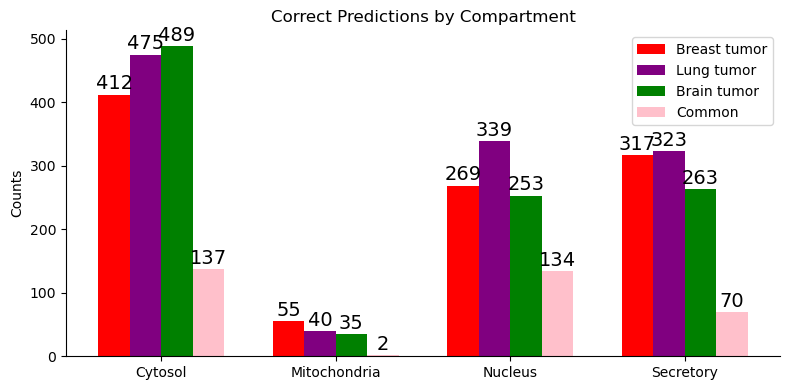

In [23]:
# Prepare data for grouped bar plot
compartments = list(lung_tumor_correct_counts.keys())
M_counts = [M_correct_counts[c] for c in compartments]
lung_counts = [lung_tumor_correct_counts[c] for c in compartments]
glioma_counts = [glioma_correct_counts[c] for c in compartments]
common_counts = [common_correct_counts[c] for c in compartments]

x = np.arange(len(compartments))
width = 0.18  # slightly smaller width for 4 bars per group

plt.figure(figsize=(8, 4))
plt.bar(x - 1.5 * width, M_counts, width, label='Breast tumor', color='red')
plt.bar(x - 0.5 * width, lung_counts, width, label='Lung tumor', color='purple')
plt.bar(x + 0.5 * width, glioma_counts, width, label='Brain tumor', color='green')
plt.bar(x + 1.5 * width, common_counts, width, label='Common', color='pink')

plt.ylabel('Counts')
plt.title('Correct Predictions by Compartment')
# Add count labels on each bar
for i in range(len(compartments)):
    plt.text(x[i] - 1.5 * width, M_counts[i] + 2, str(M_counts[i]), ha='center', va='bottom', fontsize=14)
    plt.text(x[i] - 0.5 * width, lung_counts[i] + 2, str(lung_counts[i]), ha='center', va='bottom', fontsize=14)
    plt.text(x[i] + 0.5 * width, glioma_counts[i] + 2, str(glioma_counts[i]), ha='center', va='bottom', fontsize=14)
    plt.text(x[i] + 1.5 * width, common_counts[i] + 2, str(common_counts[i]), ha='center', va='bottom', fontsize=14)
plt.xticks(x, compartments)
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.tight_layout()
# Save the figure
figure4 = plt.gcf()
figure4.savefig('/home/ec2-user/Jul2025/Enrichr_prot/Protein_Tumor_Correct_Predictions_by_Compartment.pdf', dpi=300)

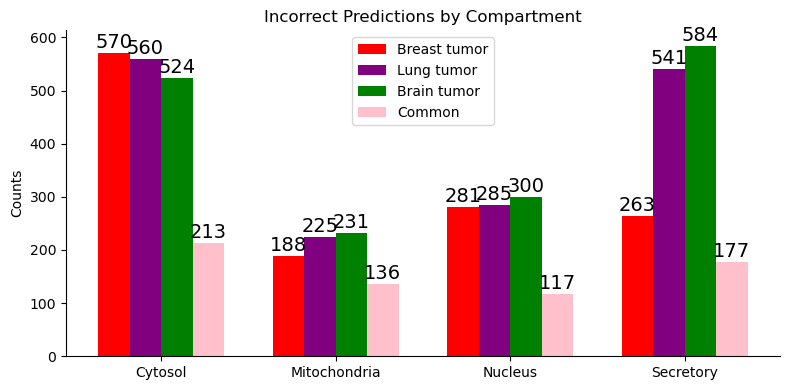

In [24]:
# Make the same figure for incorrect predictions
M_incorrect_counts = [M_incorrect_counts[c] for c in compartments]
lung_incorrect_counts = [lung_tumor_incorrect_counts[c] for c in compartments]
glioma_incorrect_counts = [glioma_incorrect_counts[c] for c in compartments]
common_incorrect_counts = [common_incorrect_counts[c] for c in compartments]

plt.figure(figsize=(8, 4))
width = 0.18
plt.bar(x - 1.5 * width, M_incorrect_counts, width, label='Breast tumor', color='red')
plt.bar(x - 0.5 * width, lung_incorrect_counts, width, label='Lung tumor', color='purple')
plt.bar(x + 0.5 * width, glioma_incorrect_counts, width, label='Brain tumor', color='green')
plt.bar(x + 1.5 * width, common_incorrect_counts, width, label='Common', color='pink')

plt.ylabel('Counts')
plt.title('Incorrect Predictions by Compartment')
# Add count labels on each bar
for i in range(len(compartments)):
    plt.text(x[i] - 1.5 * width, M_incorrect_counts[i] + 2, str(M_incorrect_counts[i]), ha='center', va='bottom', fontsize=14)
    plt.text(x[i] - 0.5 * width, lung_incorrect_counts[i] + 2, str(lung_incorrect_counts[i]), ha='center', va='bottom', fontsize=14)
    plt.text(x[i] + 0.5 * width, glioma_incorrect_counts[i] + 2, str(glioma_incorrect_counts[i]), ha='center', va='bottom', fontsize=14)
    plt.text(x[i] + 1.5 * width, common_incorrect_counts[i] + 2, str(common_incorrect_counts[i]), ha='center', va='bottom', fontsize=14)
plt.xticks(x, compartments)
# remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.tight_layout()
# Save the figure
figure5 = plt.gcf()
figure5.savefig('/home/ec2-user/Jul2025/Enrichr_prot/Protein_Tumor_Incorrect_Predictions_by_Compartment.pdf', dpi=300)

### KEGG

In [25]:
import gseapy as gp

def run_go_enrichment_plot_vertical(file_path, top_n=50, figname=''):
    """
    Perform GO enrichment on a list of genes and generate a vertical Manhattan-style plot.

    Parameters:
    - file_path (str): Path to the .txt file containing gene symbols (one per line)
    - top_n (int): Number of top GO terms to display (default: 50)
    """

    # Read gene list
    if isinstance(file_path, pd.DataFrame):
        gene_list = file_path[0].tolist()
    else:
        with open(file_path, 'r') as f:
            gene_list = [line.strip() for line in f if line.strip()]

    # Run enrichment
    enr = gp.enrichr(
        gene_list=gene_list,
        gene_sets='GO_Biological_Process_2025',
        organism='Human',
        outdir=None,
        cutoff=0.05
    )

    # Clean up and select top terms
    results = enr.results
    if results.empty:
        print("No significant GO terms found.")
        return

    results['-log10(FDR)'] = -np.log10(results['Adjusted P-value'])
    results['Gene_count'] = results['Overlap'].str.split('/').str[0].astype(int)
    results['GO_term'] = results['Term'].str.replace(r'\s*\(GO:\d+\)', '', regex=True)

    # Wrap long GO terms at ~30 characters
    def wrap_label(label, width=30):
        words = label.split()
        lines = []
        current_line = ''
        for word in words:
            if len(current_line + ' ' + word) <= width:
                current_line += (' ' + word if current_line else word)
            else:
                lines.append(current_line)
                current_line = word
        lines.append(current_line)
        return '\n'.join(lines)

    results['GO_term_wrapped'] = results['GO_term'].apply(lambda x: wrap_label(x, width=30))
    results = results.sort_values('-log10(FDR)', ascending=False).head(top_n)

    # Sort GO terms by significance for better vertical display
    results = results.sort_values('-log10(FDR)', ascending=False)

    # Vertical plot
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=results,
        y='GO_term_wrapped',
        x='-log10(FDR)',
        size='Gene_count',
        sizes=(30, 300),
        hue='-log10(FDR)',
        palette='viridis',
        edgecolor='black',
        alpha=0.9,
        legend='brief'
    )

    plt.xlabel('-log10(FDR)')
    plt.ylabel('GO Term')
    plt.title('GO Enrichment: Biological Process')
    plt.tight_layout()
    plt.legend(
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        borderaxespad=0,
        title='Overlap Size'
        )
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.savefig(f'Enrichr_prot/'+figname, bbox_inches='tight', dpi=300)
    plt.show()
    
    # Save results to a CSV file
    results.to_csv(f'Enrichr_prot/'+figname.replace('.pdf', '.csv'), index=False)
    print(f"GO enrichment results saved to {figname.replace('.pdf', '.csv')}")

In [26]:
# run_go_enrichment_plot_vertical('Enrichr_prot/Protein_tumor_common_correct_indices.txt', top_n=5, figname='Protein_Tumor_Correct_Manhattan.pdf')

In [27]:
# run_go_enrichment_plot_vertical('Enrichr_prot/Protein_tumor_common_incorrect_indices.txt', top_n=5, figname='Protein_Tumor_Incorrect_Manhattan.pdf')

In [28]:
# subset the list of incorrect indices by compartment
incorrect_indices = pd.read_csv('Enrichr_prot/Protein_tumor_common_incorrect_indices.txt', header=None, sep='\t')
label = lung_tumor_LD
cytosol_incorrect = incorrect_indices[incorrect_indices[0].isin(label[label['Localization'] == 'Cytosol'].index)]
nucleus_incorrect = incorrect_indices[incorrect_indices[0].isin(label[label['Localization'] == 'Nucleus'].index)]
mitochondria_incorrect = incorrect_indices[incorrect_indices[0].isin(label[label['Localization'] == 'Mitochondria'].index)]
secretory_incorrect = incorrect_indices[incorrect_indices[0].isin(label[label['Localization'] == 'Secretory'].index)]

print(f"Cytosol Incorrect: {len(cytosol_incorrect)}")
print(f"Nucleus Incorrect: {len(nucleus_incorrect)}")
print(f"Mitochondria Incorrect: {len(mitochondria_incorrect)}")
print(f"Secretory Incorrect: {len(secretory_incorrect)}")

Cytosol Incorrect: 213
Nucleus Incorrect: 117
Mitochondria Incorrect: 136
Secretory Incorrect: 177


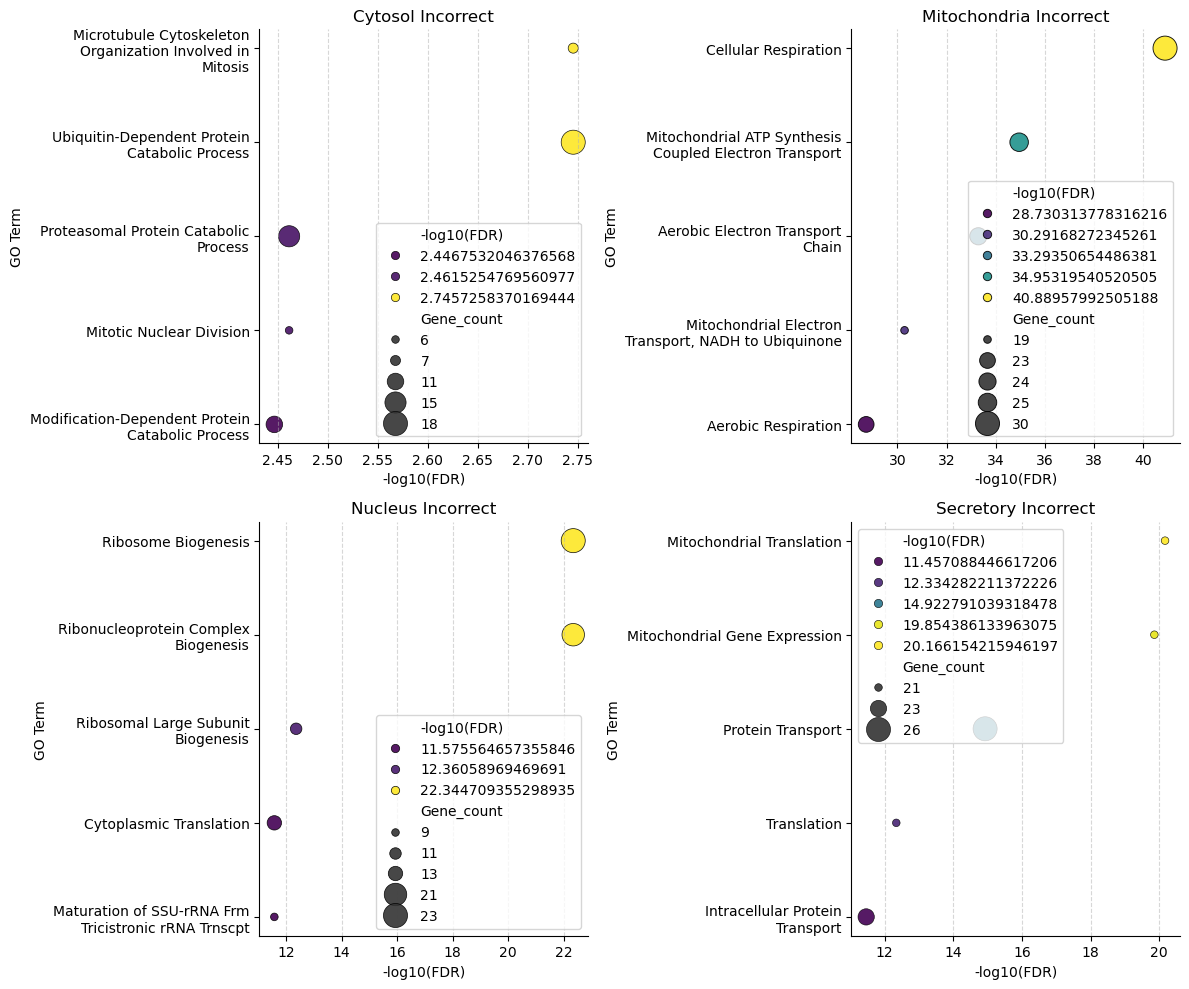

GO enrichment results saved to Enrichr_prot/Protein_Tumor_Incorrect_Manhattan_4compartments.xlsx


In [33]:
def run_go_enrichment_plot_vertical_multi(file_paths, compartment_names, top_n=5, figname=''):
    """
    Perform GO enrichment for 4 lists of genes (or 4 DataFrames), plot as 2x2 subplot, and save results to one Excel file.

    Parameters:
    - file_paths: list of 4 file paths or DataFrames
    - compartment_names: list of 4 compartment names for subplot titles
    - top_n: number of top GO terms to display per plot
    - figname: base filename for output (pdf/png/xlsx)
    """
    import gseapy as gp
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    results_dict = {}

    for idx, (file_path, comp_name) in enumerate(zip(file_paths, compartment_names)):
        # Read gene list
        if isinstance(file_path, pd.DataFrame):
            gene_list = file_path[0].tolist()
        else:
            with open(file_path, 'r') as f:
                gene_list = [line.strip() for line in f if line.strip()]

        # Run enrichment
        enr = gp.enrichr(
            gene_list=gene_list,
            gene_sets='GO_Biological_Process_2025',
            organism='Human',
            outdir=None,
            cutoff=0.05
        )

        results = enr.results
        if results.empty:
            print(f"No significant GO terms found for {comp_name}.")
            results_dict[comp_name] = pd.DataFrame()
            continue

        results['-log10(FDR)'] = -np.log10(results['Adjusted P-value'])
        results['Gene_count'] = results['Overlap'].str.split('/').str[0].astype(int)
        results['GO_term'] = results['Term'].str.replace(r'\s*\(GO:\d+\)', '', regex=True)

        def wrap_label(label, width=30):
            words = label.split()
            lines = []
            current_line = ''
            for word in words:
                if len(current_line + ' ' + word) <= width:
                    current_line += (' ' + word if current_line else word)
                else:
                    lines.append(current_line)
                    current_line = word
            lines.append(current_line)
            return '\n'.join(lines)

        results['GO_term_wrapped'] = results['GO_term'].apply(lambda x: wrap_label(x, width=30))
        results = results.sort_values('-log10(FDR)', ascending=False)
        results_top = results.head(top_n)
        results_dict[comp_name] = results

        ax = axes[idx // 2, idx % 2]
        sns.scatterplot(
            data=results_top,
            y='GO_term_wrapped',
            x='-log10(FDR)',
            size='Gene_count',
            sizes=(30, 300),
            hue='-log10(FDR)',
            palette='viridis',
            edgecolor='black',
            alpha=0.9,
            legend=True,
            ax=ax
        )
        ax.set_title(comp_name)
        ax.set_xlabel('-log10(FDR)')
        ax.set_ylabel('GO Term')
        ax.grid(axis='x', linestyle='--', alpha=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig(f'Enrichr_prot/{figname}', bbox_inches='tight', dpi=300)
    plt.show()

    # Save all results to one Excel file with multiple sheets
    excel_path = f'Enrichr_prot/{figname.replace(".pdf", ".xlsx").replace(".png", ".xlsx")}'

    with pd.ExcelWriter(excel_path) as writer:
        for comp_name, df in results_dict.items():
            df.drop(columns=['GO_term', 'GO_term_wrapped'], inplace=True)
            df.to_excel(writer, sheet_name=comp_name, index=False)
    print(f"GO enrichment results saved to {excel_path}")

# Run the GO enrichment for the common correct indices
run_go_enrichment_plot_vertical_multi(
    file_paths=[
        cytosol_incorrect,
        mitochondria_incorrect,
        nucleus_incorrect,
        secretory_incorrect
    ],
    compartment_names=['Cytosol Incorrect', 'Mitochondria Incorrect', 'Nucleus Incorrect', 'Secretory Incorrect'],
    top_n=5,
    figname='Protein_Tumor_Incorrect_Manhattan_4compartments.pdf'
)